# Определение стоимости автомобилей

Разработать модель машинного обучения для определения рыночной стоимости автомобиля. Модель обучается на исторических данных о характеристиках автомобиле и их стоимости. Важно учесть не только качество предсказания модели, но и скорость обучения и предсказания.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Предварительные выводы по подготовке данных:
1. Столбцы с пропусками: VehicleType, Gearbox, Model, FuelType, NotRepaired. Их следует рассмотреть подробнее, и, скорее всего, удалить пропуски, так как данные категориальные, и заменить их невозможно
2. Столбец в булевыми значениями, представленными в форме да/нет: NotRepaired
3. Категориальные признаки: VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired. Потребуется применить кодирование для простых моделей
4. Стоит посмотреть распределение численных признаков для выявления аномальных значений
5. Нужно разделить данные на обучающую и валидационную выборки и отделить целевой признак
6. Провести масштабирование признаков

Данные не влияющие на стоимость автомобиля:
1. DateCrawled — дата скачивания анкеты из базы
2. DateCreated — дата создания анкеты
3. PostalCode — почтовый индекс владельца анкеты (пользователя)
4. LastSeen — дата последней активности пользователя
5. RegistrationMonth

Их следует удалить

10115    819
65428    613
66333    343
44145    317
32257    317
        ... 
6725       1
6922       1
85071      1
97528      1
63931      1
Name: PostalCode, Length: 8143, dtype: int64

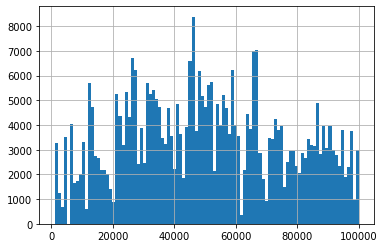

In [3]:
#Почтовый индекс
data['PostalCode'].hist(bins=100)
data['PostalCode'].value_counts()

In [4]:
#удаление пропущенных значений
#VehicleType, Gearbox, Model, FuelType, NotRepaired
data = data.fillna(value='not_listed')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


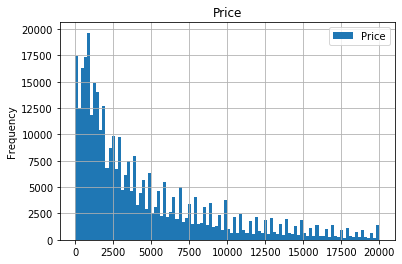

In [5]:
#price
data.plot(title='Price', kind='hist', y='Price', bins=100, grid=True)
data['Price'].value_counts()
data = data.drop(data[data['Price'] < 2].index)

In [6]:
#Численные признаки
#RegistrationYear
data['RegistrationYear'].value_counts()
display(data['RegistrationYear'].loc[data['RegistrationYear'] > 2020].value_counts())
data['RegistrationYear'].loc[data['RegistrationYear'] < 1900].value_counts()

9999    18
5000    15
6000     5
3000     5
7000     4
4000     3
2500     3
5555     2
9000     2
4500     2
5911     2
2200     1
4800     1
7800     1
2222     1
5900     1
4100     1
2066     1
5300     1
3700     1
8888     1
8500     1
7100     1
8000     1
8200     1
2800     1
2900     1
3800     1
5600     1
9450     1
2290     1
3200     1
Name: RegistrationYear, dtype: int64

1000    28
1234     4
1800     4
1500     3
1300     2
1600     2
1400     1
1001     1
1255     1
1111     1
1039     1
1602     1
Name: RegistrationYear, dtype: int64

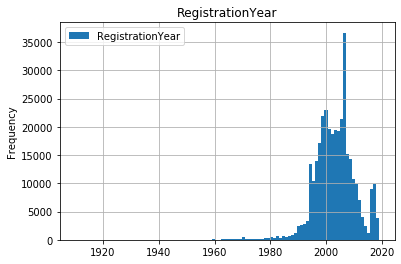

In [7]:
data = data.drop(data[data['RegistrationYear'] > 2020].index)
data = data.drop(data[data['RegistrationYear'] < 1900].index)

data.plot(title='RegistrationYear', kind='hist', y='RegistrationYear', bins=100, grid=True)

В столбце с годом регистрации автомобиля было найдено много аномальных значений (видимо, опечаток), которые пришлось удалить

0       35778
75      23251
60      15435
150     14118
101     12936
        ...  
6226        1
337         1
1105        1
1199        1
1090        1
Name: Power, Length: 697, dtype: int64

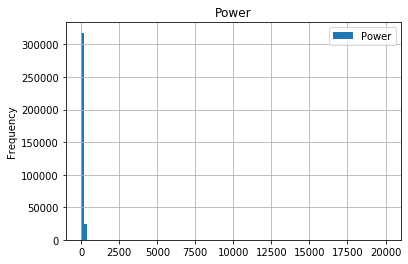

In [8]:
#Power

data.plot(title='Power', kind='hist', y='Power', bins=100, grid=True)
data['Power'].value_counts()

150000    229733
125000     35701
100000     14397
90000      11383
80000       9884
70000       8480
60000       7362
50000       6147
5000        5102
40000       4854
30000       4323
20000       3826
10000       1085
Name: Kilometer, dtype: int64

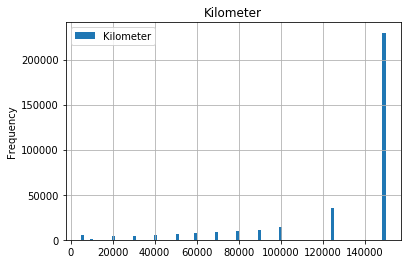

In [9]:
#Kilometer
data.plot(title='Kilometer', kind='hist', y='Kilometer', bins=100, grid=True)
data['Kilometer'].value_counts()

0    342277
Name: NumberOfPictures, dtype: int64

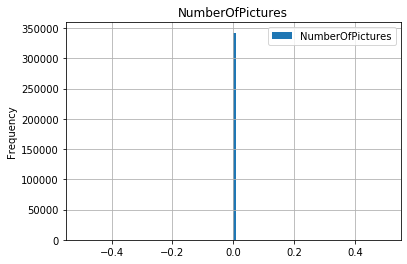

In [10]:
#NumberOfPictures
data.plot(title='NumberOfPictures', kind='hist', y='NumberOfPictures', bins=100, grid=True)
data['NumberOfPictures'].value_counts()

Пожалуй, удалю этот столбец

In [11]:
#Категориальные признаки
#VehicleType
data['VehicleType'].value_counts()

sedan          89208
small          77847
wagon          63552
not_listed     33151
bus            28283
convertible    19828
coupe          15578
suv            11769
other           3061
Name: VehicleType, dtype: int64

In [12]:
#Gearbox
data['Gearbox'].value_counts()

manual        260689
auto           64709
not_listed     16879
Name: Gearbox, dtype: int64

In [13]:
#Model
display(data['Model'].value_counts())
#sorted(data['Model'].unique())

#Дубликаты в столбце
#Заменю rangerover на range_rover
data.loc[data['Model'] == 'rangerover', 'Model'] = 'range_rover'

golf                  28158
other                 23588
3er                   19102
not_listed            17216
polo                  12582
                      ...  
serie_2                   8
rangerover                4
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: Model, Length: 251, dtype: int64

In [14]:
#FuelType
data['FuelType'].value_counts()

petrol        210178
gasoline       96997
not_listed     28920
lpg             5155
cng              551
hybrid           226
other            163
electric          87
Name: FuelType, dtype: int64

In [15]:
#Brand
data['Brand'].value_counts()

volkswagen        74145
opel              38360
bmw               35641
mercedes_benz     31246
audi              28483
ford              24383
renault           17331
peugeot           10749
fiat               9308
seat               6701
mazda              5447
skoda              5431
smart              5163
citroen            5004
nissan             4798
toyota             4528
hyundai            3526
mini               3163
volvo              3115
mitsubishi         2915
sonstige_autos     2733
honda              2707
kia                2404
suzuki             2270
alfa_romeo         2219
chevrolet          1700
chrysler           1360
dacia               889
daihatsu            774
subaru              727
porsche             724
jeep                654
land_rover          533
daewoo              531
saab                512
trabant             489
jaguar              488
rover               458
lancia              455
lada                213
Name: Brand, dtype: int64

In [16]:
#NotRepaired
data['NotRepaired'].value_counts()

no            243363
not_listed     65120
yes            33794
Name: NotRepaired, dtype: int64

In [17]:
#data = data.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis=1)
num_price = ['Kilometer', 'Power', 'RegistrationYear', 'PostalCode', 'Price']
num = ['Kilometer', 'Power', 'RegistrationYear', 'PostalCode']

for i in num_price:
    for j in num:
        if j != i:
            corr = data[i].corr(data[j])
            if (corr > 0.1) or (corr < -0.1):
                print(i, j, corr)

Kilometer RegistrationYear -0.1919698704821132
RegistrationYear Kilometer -0.1919698704821132
Price Kilometer -0.3548303002681913
Price Power 0.16063683698047862
Price RegistrationYear 0.3770580127460035


In [18]:
#Выделение целевого признака, удаление лишних признаков
target = data[['Price']]
features = data.drop(['Price'], axis=1)
features = data[['Kilometer', 'Power', 'RegistrationYear', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']]
print(target.shape, features.shape)

(342277, 1) (342277, 10)


In [19]:
#Кодирование категориальных признаков с использованием OHE
features_ohe = pd.get_dummies(features, drop_first=True)

print(features_ohe.shape)
features_ohe.head()

(342277, 311)


,Kilometer,Power,RegistrationYear,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_not_listed,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_not_listed,NotRepaired_yes
0,150000,0,1993,70435,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,125000,190,2011,66954,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,125000,163,2004,90480,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,150000,75,2001,91074,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,90000,69,2008,60437,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
#Разделение на выборки
#Для простых моделей
features_ohe_train, features_ohe_, target_train, target_ = train_test_split(features_ohe, target, test_size=0.4, random_state=42)
features_ohe_test, features_ohe_valid, target_test, target_valid = train_test_split(features_ohe_, target_, test_size=0.5, random_state=42)

#Для градиентного бустинга
features_train, features_, target_train, target_ = train_test_split(features, target, test_size=0.4, random_state=42)
features_test, features_valid, target_test, target_valid = train_test_split(features_, target_, test_size=0.5, random_state=42)

In [21]:
#Кодирование категориальных признаков с использованием LE
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
features_le_train = features_train
features_le_valid = features_valid
features_le_test = features_test

for row in cat:
    le = LabelEncoder()
    le.fit(features_train[row])
    features_le_train[row] = le.transform(features_train[row])
    features_le_valid[row] = le.transform(features_valid[row])
    features_le_test[row] = le.transform(features_test[row])
    
print(features_le_test.shape)
features_le_test.head()

(68455, 10)


,Kilometer,Power,RegistrationYear,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,PostalCode
136937,150000,105,2011,5,1,116,2,38,0,12045
70781,150000,101,2000,5,1,103,7,10,0,33332
19961,150000,86,2007,0,1,189,7,31,0,97720
110491,125000,58,2004,6,1,227,7,27,2,88213
15253,150000,190,1987,2,1,167,7,26,0,65594


Возможно, стоит отнести год выпуска машины к категориальным признакам, как минимум, потому что он дискретный. Но потому что он численный, он не обрабатывается OHE, а масштабируется. На сколько это критично?

In [22]:
#Линейная регрессия обучение
model_1 = LinearRegression()
model_1.fit(features_ohe_train, target_train)
#Линейная регрессия предсказание
pred_1 = model_1.predict(features_ohe_valid)
print('OHE', np.sqrt(mean_squared_error(target_valid, pred_1)))

OHE 2844.9419772508454


In [23]:
#Линейная регрессия обучение
model_1 = LinearRegression()
model_1.fit(features_le_train, target_train)
#Линейная регрессия предсказание
pred_1 = model_1.predict(features_le_valid)
print('LE', np.sqrt(mean_squared_error(target_valid, pred_1)))

LE 3480.75470403425


Видно, что линейная регрессия на OHE дaeт меньшую ошибку, чем на LE. Поэтому я оставлю кодирование OHE

In [24]:
#Масштабирование численных признаков
pd.options.mode.chained_assignment = None
num = ['Kilometer', 'Power', 'RegistrationYear', 'PostalCode']
scaler = StandardScaler()
scaler.fit(features_train[num])
features_ohe_train[num] = scaler.transform(features_ohe_train[num])
features_ohe_valid[num] = scaler.transform(features_ohe_valid[num])
features_ohe_test[num] = scaler.transform(features_ohe_test[num])
features_train[num] = scaler.transform(features_train[num])
features_valid[num] = scaler.transform(features_valid[num])
features_test[num] = scaler.transform(features_test[num])

display(features_ohe_train.head())
display(features_valid.head())

,Kilometer,Power,RegistrationYear,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_not_listed,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_not_listed,NotRepaired_yes
353593,-0.091703,-0.085034,0.518432,1.083154,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
28857,0.577696,0.123777,0.109133,-1.451408,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5922,0.577696,-0.058932,1.746327,-0.248054,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94678,0.577696,-0.048492,-0.436598,-0.760167,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163026,0.577696,-0.267743,-0.982329,-0.954416,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,Kilometer,Power,RegistrationYear,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,PostalCode
77947,-1.296621,-0.299065,-0.163733,6,1,200,7,9,0,0.885717
293905,-0.091703,-0.346047,-1.118762,6,1,83,7,24,1,-0.788545
234560,0.577696,0.510076,-0.436598,3,1,167,7,1,1,-1.648222
234572,-0.091703,-0.111135,-0.982329,5,1,136,7,27,0,-0.645531
322074,0.577696,0.149878,1.200596,7,1,135,2,10,0,-1.898331


В ходе подготовки данных были удалены пропуски, аномальные значения, признаки, не влияющие на целевой признак. Категориальные признаки были закодированы в численные для обработки простыми моделями. Численные признаки были отмасштабированы.
Так же данные были разделены на обучающую и валидационную выборки

## Обучение моделей

В данном разделе я буду искать оптимальные модели среди простых (линейная регрессия и случайный лес) и градиентного бустинга. Затем я обучу их и засеку время, потраченное на обучение

In [25]:
#Градиентный бустинг

#меняю тип данных в столбцах на категориальные
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
        features_train[col] = features_train[col].astype('category')
        features_valid[col] = features_valid[col].astype('category')
        features_test[col] = features_test[col].astype('category')

In [26]:
%%time
train_data = lgb.Dataset(features_train, label=target_train)
validation_data = lgb.Dataset(features_valid, label=target_valid)

param = {'objective':'regression', 'metric':'rmse',  'num_iterations':5, 'max_depth':100}

model_3 = lgb.train(param, train_data, valid_sets=[validation_data])
pred_3 = model_3.predict(features_valid)

np.sqrt(mean_squared_error(target_valid, pred_3))

[1]	valid_0's rmse: 4207.99
[2]	valid_0's rmse: 3924.9
[3]	valid_0's rmse: 3679.26
[4]	valid_0's rmse: 3458.55
[5]	valid_0's rmse: 3262.69
CPU times: user 24.4 s, sys: 19.9 ms, total: 24.4 s
Wall time: 24.6 s


3262.6854457860413

20 2024.5131940128183
40 1777.1582598944756
60 1723.646847847273
80 1698.3687626158905
100 1680.6856892483406
120 1669.9281279178988
140 1662.621598093995
160 1655.4930737263417
180 1648.9898399609929
200 1643.2897797743242
200 1643.2897797743242


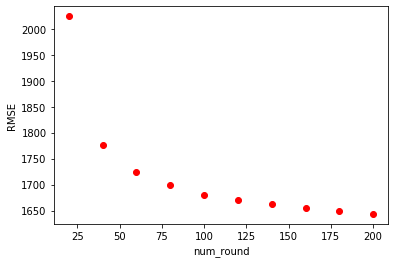

In [27]:
#Изменение гиперпараметра: количество итераций
rmse_list = []
i_list = []
rmse_min = 5000

for i in range(20, 201, 20):    
    param['num_iterations'] = i
    model_3 = lgb.train(param, train_data, valid_sets=[validation_data], verbose_eval=0)
    pred_3 = model_3.predict(features_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, pred_3))
    rmse_list.append(rmse)
    i_list.append(i)
    print(i, rmse)
    
    if rmse < rmse_min:
        rmse_min = rmse
        i_min = i
        
print(i_min, rmse_min)

plt.xlabel('num_round')
plt.ylabel('RMSE')
plt.plot(i_list, rmse_list, 'ro')

1 2216.3109845625295
2 1897.193789817563
3 1770.6602396351943
4 1714.585292619152
5 1668.982284137275
6 1653.9691099590152
7 1653.367689782767
8 1648.1812941537814
9 1645.2446155733965
10 1645.530196073401
11 1645.7686429904734
12 1644.8909347509666
13 1641.2819175508675
14 1638.1039866163421
15 1643.2897797743242
14 1638.1039866163421


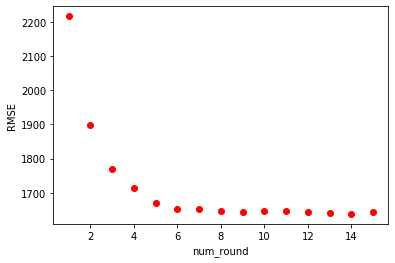

In [28]:
#Изменение максимальной глубины дерева
rmse_list = []
n_list = []
rmse_min = 5000
param['num_iterations'] = 200

for n in range(1, 16):    
    param['max_depth'] = n
    model_3 = lgb.train(param, train_data, valid_sets=[validation_data], verbose_eval=0)
    pred_3 = model_3.predict(features_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, pred_3))
    rmse_list.append(rmse)
    n_list.append(n)
    print(n, rmse)
    
    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)

plt.xlabel('num_round')
plt.ylabel('RMSE')
plt.plot(n_list, rmse_list, 'ro')

Оптимальная модель была найдена при гиперпараметрах: максимальной глубине 12 и количестве итераций 200

26 1690.242487525774


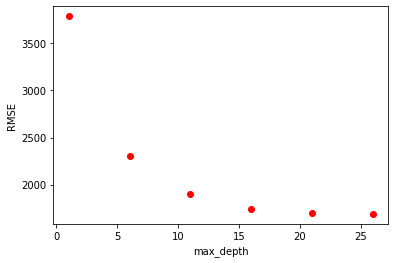

In [29]:
#Лес

#Ищу максимальную глубину деревьев
rmse_list = []
d_list = []
rmse_min = 5000

for d in range(1, 30, 5):    
    model_2 = RandomForestRegressor(random_state=42, n_estimators=10, max_depth=d)
    model_2.fit(features_ohe_train, target_train)
    pred_2 = model_2.predict(features_ohe_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, pred_2))
    rmse_list.append(rmse)
    d_list.append(d)
    
    if rmse < rmse_min:
        rmse_min = rmse
        d_min = d
        
print(d_min, rmse_min)

plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.plot(d_list, rmse_list, 'ro')

41 1643.5892167391214


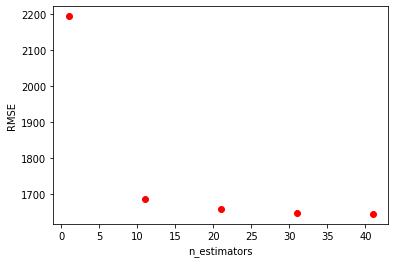

In [30]:
#Ищу количество деревьев
rmse_list = []
n_list = []
rmse_min = 5000

for n in range(1, 50, 10):    
    model_2 = RandomForestRegressor(random_state=42, n_estimators=n, max_depth=d_min)
    model_2.fit(features_ohe_train, target_train)
    pred_2 = model_2.predict(features_ohe_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, pred_2))
    rmse_list.append(rmse)
    n_list.append(n)
    
    if rmse < rmse_min:
        rmse_min = rmse
        n_min = n
        
print(n_min, rmse_min)

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.plot(n_list, rmse_list, 'ro')

Оптимальными гиперпараметрами случайного леса оказались: d=26, n=41.


Но на обоих графиках значения снижаются очень медленно после 20 (примерно), поэтому стоит проверить несколько сочетаний значений для значения ошибки и времени, которое уходит на выполнение кода

In [31]:
%%time

model_2 = RandomForestRegressor(random_state=42, n_estimators=25, max_depth=26)
model_2.fit(features_ohe_train, target_train)
pred_2 = model_2.predict(features_ohe_valid)
np.sqrt(mean_squared_error(target_valid, pred_2))

CPU times: user 2min 35s, sys: 433 ms, total: 2min 35s
Wall time: 2min 37s


1652.405272384675

In [32]:
%%time

model_2 = RandomForestRegressor(random_state=42, n_estimators=20, max_depth=26)
model_2.fit(features_ohe_train, target_train)
pred_2 = model_2.predict(features_ohe_valid)
np.sqrt(mean_squared_error(target_valid, pred_2))

CPU times: user 2min 4s, sys: 361 ms, total: 2min 5s
Wall time: 2min 6s


1658.6306748493262

In [33]:
%%time

model_2 = RandomForestRegressor(random_state=42, n_estimators=25, max_depth=20)
model_2.fit(features_ohe_train, target_train)
pred_2 = model_2.predict(features_ohe_valid)
np.sqrt(mean_squared_error(target_valid, pred_2))

CPU times: user 2min 18s, sys: 349 ms, total: 2min 18s
Wall time: 2min 20s


1673.6451738572312

In [34]:
%%time

model_2 = RandomForestRegressor(random_state=42, n_estimators=41, max_depth=26)
model_2.fit(features_ohe_train, target_train)
pred_2 = model_2.predict(features_ohe_valid)
np.sqrt(mean_squared_error(target_valid, pred_2))

CPU times: user 4min 11s, sys: 626 ms, total: 4min 12s
Wall time: 4min 15s


1643.5892167391214

Оптимальным сочетанием гиперпараметров с учетом времени выполнения (1min 27s) стали: d=26, n=25

## Анализ моделей

In [35]:
%%time
#Простые модели
#Линейная регрессия обучение
model_1 = LinearRegression()
model_1.fit(features_ohe_train, target_train)

CPU times: user 20.6 s, sys: 7.29 s, total: 27.9 s
Wall time: 27.9 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
%%time
#Случайный лес обучение
model_2 = RandomForestRegressor(random_state=42, n_estimators=25, max_depth=26)
model_2.fit(features_ohe_train, target_train)

CPU times: user 2min 30s, sys: 454 ms, total: 2min 30s
Wall time: 2min 32s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=26,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [37]:
%%time
#Градиентный бустинг обучение
param['num_iterations'] = 200
param['max_depth'] = 12
model_3 = lgb.train(param, train_data, valid_sets=[validation_data], verbose_eval=0)

CPU times: user 4min 53s, sys: 1.09 s, total: 4min 54s
Wall time: 4min 57s


In [38]:
%%time
#Линейная регрессия предсказание
rmse = [0, 0, 0, 0]
pred_1 = model_1.predict(features_ohe_test)
rmse[0] = np.sqrt(mean_squared_error(target_test, pred_1))

CPU times: user 93.4 ms, sys: 56.8 ms, total: 150 ms
Wall time: 186 ms


In [39]:
%%time
#Случайный лес предсказание
pred_2 = model_2.predict(features_ohe_test)
rmse[1] = np.sqrt(mean_squared_error(target_test, pred_2))

CPU times: user 944 ms, sys: 73 ms, total: 1.02 s
Wall time: 1.07 s


In [40]:
%%time
#Градиентный бустинг предсказание
pred_3 = model_3.predict(features_test)
rmse[2] = np.sqrt(mean_squared_error(target_test, pred_3))

CPU times: user 2.41 s, sys: 3.93 ms, total: 2.41 s
Wall time: 2.37 s


In [41]:
#Dummy
model_4 = DummyRegressor()
model_4.fit(features_ohe_train, target_train)
pred_4 = model_4.predict(features_ohe_test)
rmse[3] = np.sqrt(mean_squared_error(target_test, pred_4))

In [42]:
columns = ['Модель', 'RMSE']
name = ['Линейная регрессия', 'Случайный лес', 'Градиентный бустинг', 'Dummy']
results = pd.DataFrame([name, rmse], columns)
display(results)

,0,1,2,3
Модель,Линейная регрессия,Случайный лес,Градиентный бустинг,Dummy
RMSE,2829.32,1660.8,1634.85,4502.71


**Вывод**
В ходе данной работы были опробованы различные модели для определения стоимости автомобиля на основе его характеристик: линейная регрессия, случайный лес и градиентный бустинг. Для каждой модели были найдены оптимальные гиперпараметры на основе метрики RMSE.

Полученные результаты:
1. Наиболее точные предсказания имеет градиентный бустинг
2. Быстрее всего обучается и предсказывает линейная регрессия
3. Медленнее всего обучается случайный лес

То есть оптимальной моделью является градиентный бустинг с гиперпараметрами количество итераций = 200
максимальная глубина = 12, сочетающий в себе скорость работы и точность предсказаний. Так же градиентный бустинг не требует предварительной обработки категориальных данных, как более простые модели.